In [26]:
#===============================================================================
# rules: jupyter notebook (copyright: Neuronycs 2023)
#===============================================================================

import numpy
from numpy import transpose as trn
from numpy import ones, arange, copy, array
from ypstruct import struct

#from carabao.screen import norm1,select

#=============================================================================
# select function
#=============================================================================

def select(K,c):
    """
    select(): select a set of neuron outputs given an index matrix/list and
              a context vector c

                  c = [0,0,0,1,1, 1,1,0,0,0]
                  g = [0,1,2];
                  v = select(g,c)

                  K = numpy.array([[4,5,6,7],[6,7,8,9]])
                  V = select(K,c)

              see also: Cell, Rcell, hash, norm1
    """
    if type(K).__name__ == 'list':
        return [c[k] for k in K];

    if type(K).__name__ != 'ndarray':
        raise Exception('numpy array expected')

    V = copy(K);       # make a copy
    for i in range(0,K.shape[0]):
        for j in range(0,K.shape[1]):
            V[i,j] = c[K[i,j]]

    return V

#===============================================================================
# helper: vector 1-norm or matrix 1-norm
#===============================================================================

def norm1(M):    # max of row sums
    """
    norm1(): vector 1-norm or matrix 1-norm

                 v = [2,-3,-1]      # list representation of vector
                 n = norm1(v)       # sum of abs values => n = 6

                 V = numpy.array([[2,-3,-1],[1,0,-1]])
                 n = norm1(V)       # max of row 1-norm => n = max(6,2) =6

             see also: Cell, select, hash
    """
    if type(M).__name__ == 'list':
        return sum(M)

    result = 0
    for j in range(0,M.shape[0]):
        sumj = M[j].sum().item()
        result = result if sumj < result else sumj
    return result

#=============================================================================
# class Cell
#=============================================================================

class Rcell:
    """
    Rcell: class Rcell - modelling HTM cell algorithm

        from carabao.screen import Monitor
        from carabao.cell import Cell,toy
        from numpy import ones

        mon = Monitor(m=1,n=3)
        k,g,K,P,c = toy('cell')
        cell = Rcell(mon,k,g,K,P)
        cell.plot(i=0,j=0)    # plot at monitor location i,j

        cell.u = cell.y = cell.x = cell.b = 1
        cell.plot(i=0,j=1)    # plot at monitor location i,j

        v = [1,0,1,0];  V = ones((2,5));  E = (cell.P >= 0.5)*V
        cell.plot(0,2,v,E)
    """

    def __init__(self,mon,k,g,K,P):
        self.mon = mon.copy()  # Monitor(mon.screen.m,mon.screen.n,mon.verbose)
        zero = [0 for i in range(0,P.shape[0])]

            # input, output, state variables

        self.y = 0                     # cell output (axon)
        self.x = 0                     # predictive state
        self.b = 0                     # burst state
        self.s = zero                  # spike state
        self.P = P                     # permanence matrix (state)
        self.aux = struct()
        self.aux.u = 0                 # basal (feedforwad) input
        self.aux.c = []                # context input
        self.aux.v = [0,0,0,0]         # group outputs
        self.aux.V = 0*P               # pre-synaptic signals
        self.aux.W = 0*P               # dendritic weights
        self.aux.E = 0*P               # empowerment matrix
        
            # parameters and auxilliary variables

        self.config(k,g,K)
        self.x_ = 0                    # auxilliary: x(t+1)
        self.P_ = self.P               # auxilliary: P(t+1)

    def config(self,k,g,K):
        self.eta = 0.5                 # synaptic threshold
        self.theta = 2                 # dendritic threshold
        self.pdelta = 0.04             # positive learning delata
        self.ndelta = 0.02             # negative learning delta
        self.k = k;
        self.g = g;
        self.K = K;

    def transition(self):              # state & permanence transition
        self.x = self.x_               # predictive state transition
        self.P = self.P_               # permanence state transition
    """
    def update(self,c):                # update context with current output
        c[self.k] = self.y             # update context with changed output
        return c                       # return updated context

    def phase1(self,u,c):              # cell algo phase 1: update context
        self.transition()              # first perform state transition

            # rule 1: excited (u=1) & predictive (x=1) cells get active (y=1)

        self.u = u;                    # store input locally
        self.y = u * self.x            # excited & predictive cells get active
        #self.b = 0                    # clear burst state

            # update context c[k] with updated output y
            # note: c is only updated but not used for processing

            # record/log quantities (if verbose)

        self.mon.record(self,u,c)      # record current cell state
        return self.update(c)          # return updated context

    def phase2(self,u,c):              # cell algo phase 2: bursting
        self.u = u

           # rule 2: excited cells in a non-predictive group get bursting

        v = [c[k] for k in self.g]     # the group's outputs
        self.b = u * (sum(v) == 0)     # set cell's burst state

           # important: don't change output (and context vector) in this phase
           # before all cells in the context have determined their burst state

        self.mon.record(self,u,c,v)
        return self.update(c)          # return updated context

    def phase3(self,u,c):              # cell algo phase 3: process context
        self.u = u

            # rule 3: excited bursting cells get active

        self.y = self.y or (u * self.b)

            # rule 4: excided empowered dendritic segments are spiking

        V = self.select(c,self.K)          # pre-synaptic signals
        W = (self.P >= self.eta)           # synaptic (binary) weights
        E = V * W                          # synapitcs matrix
        self.s = self.spike(u,E,self.theta)

            # rule 5: spiking dentrites of activated cells are learning
            # (calc permanences after transition)

        L = self.learn(E)
        D = self.y * (L*E*self.pdelta - L*self.ndelta)

        self.P_ = self.P + D           # learning (permanences after transition)

            # rule 6: active cells with spiking dendrites get predictive
            # (calc state after transition)

        self.x_ = self.y * max(self.s) # get predictive if any segment spikes

            # record this stuff

        self.mon.record(self,u,c,0,V,W,E,L,D)
        return self.update(c)          # return updated context

    def phase(self,ph,u,c):            # cell algo phase i
        if ph == 1:
            return self.phase1(u,c)
        elif ph == 2:
            return self.phase2(u,c)
        elif ph == 3:
            return self.phase3(u,c)
        else:
            raise Exception("bad phase")
    """
    def group(self,c,g):
        return [c[g[k]] for k in range(0,len(g))]

    def learn(self,E):                  # learning vector
        d,s = E.shape
        l = [];  p = []
        for mu in range(0,d):
            norm = sum(E[mu]).item()
            l.append(norm)
            p.append(int(norm >= self.theta))
        L = trn(array([p])) @ ones((1,s))
        return L

    def update(self,u,c,args):
        self.aux.u = u                 # store for analysis
        self.aux.c = c                 # store for analysis
        c[self.k] = self.y             # update context with changed output
        self.mon.update(self,args)
        if args['rule'] == 3:
            self.aux.v = args['v']
        if args['rule'] == 4:
            self.aux.V = args['V']
            self.aux.W = args['W']
            self.aux.E = args['E']

        return c

    def select(self,c,K):              # pre-synaptic signals
        V = 0*K
        print("K =",K,"V =",V)
        for mu in range(0,K.shape[0]):
            for nu in range(0,K.shape[1]):
                V[mu,nu] = c[K[mu,nu]];
        return V

    def spike(self,u,E,theta):         # generate spike vector from Empowerment
        return [u * (sum(E[mu]) >= theta)
                for mu in range(0,E.shape[0])]

     # === rule 1: spiking neurons get always predictive ===

    def rule1(self,u,c):
        self.x = max(self.s)  # cell gets predictive when any dendrite spikes
        self.s = None
        return self.update(u,c,{'rule':1})

      # === rule 2: excited predictive cells get active ===  

    def rule2(self,u,c):   
        self.y = u * self.x            # excited & predictive cells get active
        return self.update(u,c,{'rule':2})

      # === rule 3: excited neurons in non-predictive groups burst

    def rule3(self,u,c):
        v = [c[k] for k in self.g]     # v = c[g] - the group's outputs
        self.b = u * (sum(v) == 0)     # set cell's burst state

           # important: don't change output (and context vector) in this phase
           # before all cells in the context have determined their burst state

        return self.update(u,c,{'rule':3, 'v':v})

      # === rule 4: excited empowered dendritic segments are spiking ===

    def rule4(self,u,c):
        V = self.select(c,self.K)                 # pre-synaptic signals
        W = (self.P >= self.eta)*1                # synaptic (binary) weights
        E = V * W                                 # empowerment matrix
        self.s = [u * (sum(E[mu]) >= self.theta)  # spike vector
                  for mu in range(0,E.shape[0])]
        print("rule4: V:\n",V,"\nrule4: W:\n",W,"\nrule4: E:\n",E)
        return self.update(u,c,{'rule':4, 'V':V, 'W':W, 'E':E})
    
    def plot(self,i=None,j=None,v=None,W=None,E=None,xlabel=None,head=None,foot=None):
        self.u = self.aux.u # for compatibility
        v = self.aux.v if v is None else v
        #V = self.aux.V if V is None else V
        W = self.aux.W if W is None else W
        E = self.aux.E if E is None else E
    
        self.mon.plot(self,i,j,v,W,E)
        if xlabel is not None:
            self.mon.xlabel(j,xlabel)
        if head is not None:
            self.mon.head(head)
        if foot is not None:
            self.mon.foot(foot)

    def set(self,u=None,c=None,x=None,y=None,b=None,s=None,v=None,V=None,W=None,E=None):
        self.aux.u = self.aux.u if u is None else u 
        self.c = self.aux.c if c is None else c 
        self.x = self.x if x is None else x 
        self.y = self.y if y is None else y 
        self.b = self.b if b is None else b 
        self.s = self.s if s is None else s
        self.aux.v = self.aux.v if v is None else v
        self.aux.V = self.aux.V if V is None else V
        self.aux.W = self.aux.W if W is None else W
        self.aux.E = self.aux.E if E is None else E
        return self

#===============================================================================
# class Toy
# - usage: k,g,P,K = Toy('cell')
#===============================================================================

def toy(tag):
    """
    Toy: create a toy object

       k,g,K,P,c = toy('cell')
       k,g,K,P,c = toy('mini3')
    """
    if tag == 'cell':
        k = 0                        # cell index
        g = [0,1,2,3]                # group indices
        K = array([[1,3,5,7,9],[3,4,5,6,7]])
        P = array([[0.12,0.32,0.54,0.77,0],[0,0.61,0.45,0,0]])
        c = [0,0,0,0,1,1,0,1,1,0];
        return k,g,K,P,c
    elif tag == 'mini3':
        k = [0,1,2]                  # cell indices
        g = [0,1,2]                  # group indices
        K0 = array([[3,4,5,6,7],[1,3,5,7,9]])
        K1 = array([[4,5,6,7,8],[2,4,5,6,7]])
        K2 = array([[5,6,7,8,9],[0,3,7,8,9]])
        P0 = array([[0.5,0.6,0.1,0.2,0.3],[0.0,0.6,0.4,0.0,0.0]])
        P1 = array([[0.1,0.3,0.5,0.1,0.0],[0.0,0.6,0.5,0.7,0.0]])
        P2 = array([[0.0,0.1,0.5,0.7,0.1],[0.0,0.1,0.3,0.8,0.0]])
        K = [K0,K1,K2]
        P = [P0,P1,P2]
        c = [0,0,0,0,1,1,0,0,1,1];
        return k,g,K,P,c
    else:
        raise Exception('unknown tag')

def hello():
	print("hello, world!")


after init:    c = [0, 0, 0, 0, 1, 1, 0, 1, 1, 0]
after rule 1a: c = [0, 0, 0, 0, 1, 1, 0, 1, 1, 0]
after rule 1b: c = [0, 0, 0, 0, 1, 1, 0, 1, 1, 0]


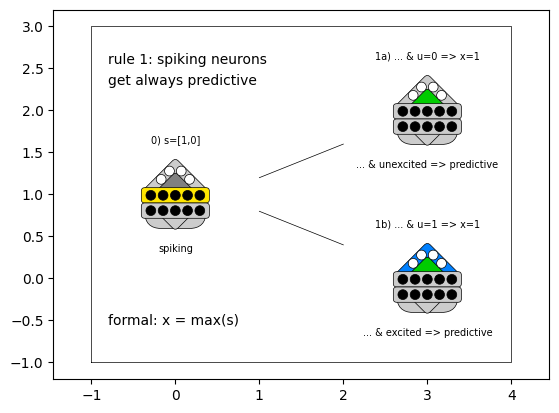

In [27]:
# === rule 1: spiking neurons get always predictive ===

from carabao.screen import Monitor
mon = Monitor(m=3,n=4)

k,g,K,P,c = toy('cell'); 
print("after init:    c =",c)

    # 0) create a cell and initialize it as spiking

cell = Rcell(mon,k,g,K,P).set(s=[1,0])
cell.plot(1,0,head='0) s=[1,0]',foot='spiking')

   # 1a) apply rule 1 to an unexcited spiking cell

cell.set(s=[1,0]);  c = cell.rule1(u=0,c=c)
cell.plot(0,3,head='1a) ... & u=0 => x=1',foot='... & unexcited => predictive')
mon.line([1,2],[1+0.2,1+0.6]);
print("after rule 1a: c =",c)

   # 1b) apply rule 1 to an excited spiking cell

cell.set(s=[1,0]);  c = cell.rule1(u=1,c=c)
cell.plot(2,3,head='1b) ... & u=1 => x=1',foot='... & excited => predictive')
mon.line([1,2],[1-0.2,1-0.6]);
print("after rule 1b: c =",c)

mon.text(-0.8,2.6,'rule 1: spiking neurons',ha='left')
mon.text(-0.8,2.35,'get always predictive',ha='left')
mon.text(-0.8,-0.5,'formal: x = max(s)',ha='left')

after init:    c = [0, 0, 0, 0, 1, 1, 0, 1, 1, 0]
after rule 2a: c = [0, 0, 0, 0, 1, 1, 0, 1, 1, 0]
after rule 2b: c = [1, 0, 0, 0, 1, 1, 0, 1, 1, 0]


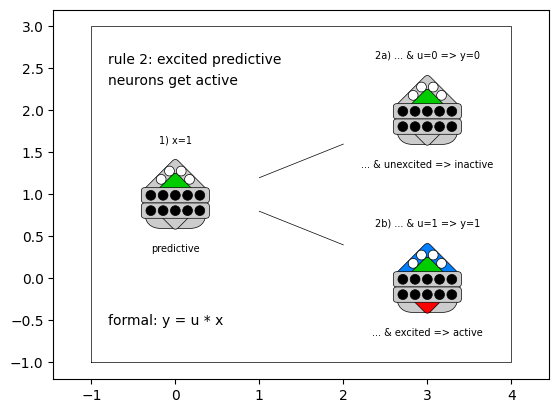

In [28]:
# === rule 2: excited predictive cells get active ===  

from carabao.screen import Monitor
mon = Monitor(m=3,n=4)

mon.text(-0.8,2.6,'rule 2: excited predictive',ha='left')
mon.text(-0.8,2.35,'neurons get active',ha='left')

k,g,K,P,c = toy('cell'); 
print("after init:    c =",c)

    # 1) create a cell and initialize it as predictive

cell = Rcell(mon,k,g,K,P).set(x=1)
cell.plot(1,0,head='1) x=1',foot='predictive')

   # 2a) apply rule 2 to an unexcited predictive cell

cell.set(x=1);  c = cell.rule2(u=0,c=c)
cell.plot(0,3,head='2a) ... & u=0 => y=0',foot='... & unexcited => inactive')
mon.line([1,2],[1+0.2,1+0.6]);
print("after rule 2a: c =",c)

   # 2b) apply rule 2 to an excited predictive cell

cell.set(x=1);  c = cell.rule2(u=1,c=c)
cell.plot(2,3,head='2b) ... & u=1 => y=1',foot='... & excited => active')
mon.line([1,2],[1-0.2,1-0.6]);
print("after rule 2b: c =",c)

mon.text(-0.8,-0.5,'formal: y = u * x',ha='left')

after init:    c = [0, 0, 0, 0, 1, 1, 0, 1, 1, 0]
after rule 3a: c = [0, 0, 0, 0, 1, 1, 0, 1, 1, 0] , v = [0, 0, 0, 0]
after rule 3b: c = [0, 0, 0, 0, 1, 1, 0, 1, 1, 0] , v = [0, 0, 0, 0]
after rule 3b: c = [0, 1, 1, 0, 1, 1, 0, 0, 1, 1] , v = [0, 1, 1, 0]


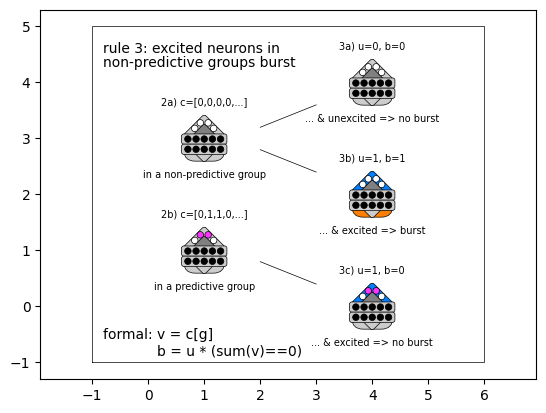

In [29]:
# === rule 3: excited neurons in non-predictive groups burst

from carabao.screen import Monitor
mon = Monitor(m=5,n=6)

mon.text(-0.8,4.6,'rule 3: excited neurons in',ha='left')
mon.text(-0.8,4.35,'non-predictive groups burst',ha='left')

k,g,K,P,c = toy('cell'); 
print("after init:    c =",c)

    # 2a) create a cell and initialize it as spiking

cell = Rcell(mon,k,g,K,P).set()
cell.plot(1,1,head='2a) c=[0,0,0,0,...]',foot='in a non-predictive group')

   # 3a) let an unexcited cell spike and apply rule 1

cell.set(); c = cell.rule3(u=0,c=c)
cell.plot(0,4,head='3a) u=0, b=0',foot='... & unexcited => no burst')
mon.line([2,3],[3+0.2,3+0.6]);
print("after rule 3a: c =",c,", v =",cell.mon.data.v)

   # 3b) let an excited cell spike and apply rule 1

cell.set();  c = cell.rule3(u=1,c=c)
cell.plot(2,4,head='3b) u=1, b=1',foot='... & excited => burst')
mon.line([2,3],[3-0.2,3-0.6]);
print("after rule 3b: c =",c,", v =",cell.mon.data.v)

    # 2b) create a cell in a predicting group

cell = Rcell(mon,k,g,K,P).set(v=[0,1,1,0])
cell.plot(3,1,head='2b) c=[0,1,1,0,...]',foot='in a predictive group')

    # 3c) let an excited cell spike and apply rule 1

c = [0, 1, 1, 0, 1, 1, 0, 0, 1, 1]
cell.set(c);  c = cell.rule3(u=1,c=c)
cell.plot(4,4,head='3c) u=1, b=0',foot='... & excited => no burst')
mon.line([2,3],[1-0.2,1-0.6]);
print("after rule 3b: c =",c,", v =",cell.mon.data.v)

    # footer

mon.text(-0.8,-0.5,'formal: v = c[g]',ha='left')
mon.text(0.16,-0.79,'b = u * (sum(v)==0)',ha='left')

after init:    c = [0, 0, 0, 0, 1, 1, 0, 1, 1, 0]
K = [[1 3 5 7 9]
 [3 4 5 6 7]] V = [[0 0 0 0 0]
 [0 0 0 0 0]]
rule4: V:
 [[0 0 1 1 0]
 [0 1 1 0 1]] 
rule4: W:
 [[0 0 1 1 0]
 [0 1 0 0 0]] 
rule4: E:
 [[0 0 1 1 0]
 [0 1 0 0 0]]
after rule 4a: c = [0, 0, 0, 0, 1, 1, 0, 1, 1, 0]
K = [[1 3 5 7 9]
 [3 4 5 6 7]] V = [[0 0 0 0 0]
 [0 0 0 0 0]]
rule4: V:
 [[0 0 1 1 0]
 [0 1 1 0 1]] 
rule4: W:
 [[0 0 1 1 0]
 [0 1 0 0 0]] 
rule4: E:
 [[0 0 1 1 0]
 [0 1 0 0 0]]
after rule 4b: c = [0, 0, 0, 0, 1, 1, 0, 1, 1, 0]


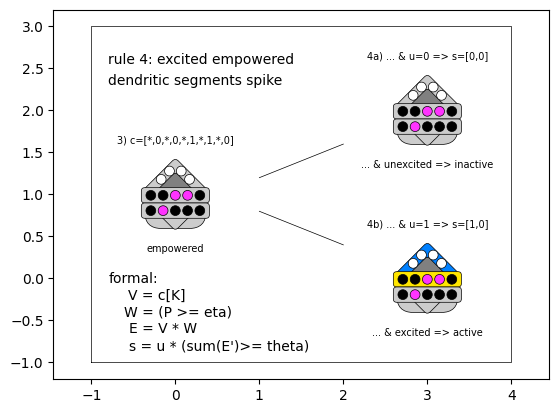

In [30]:
# === rule 4: excided empowered dendritic segments are spiking ===

from carabao.screen import Monitor
mon = Monitor(m=3,n=4)

mon.text(-0.8,2.6,'rule 4: excited empowered',ha='left')
mon.text(-0.8,2.35,'dendritic segments spike',ha='left')

k,g,K,P,c = toy('cell'); 
W = (P>=0.5)*1;  E = W;
print("after init:    c =",c)

    # 3) create a cell and initialize it as empowered

cell = Rcell(mon,k,g,K,P).set(W=W,E=E)
cell.plot(1,0,head='3) c=[*,0,*,0,*,1,*,1,*,0]',foot='empowered')

   # 4a) apply rule 4 to an unexcited predictive cell

cell.set();  c = cell.rule4(u=0,c=c)
cell.plot(0,3,head='4a) ... & u=0 => s=[0,0]',foot='... & unexcited => inactive')
mon.line([1,2],[1+0.2,1+0.6]);
print("after rule 4a: c =",c)

   # 4b) apply rule 4 to an excited predictive cell

cell.set();  c = cell.rule4(u=1,c=c)
cell.plot(2,3,head='4b) ... & u=1 => s=[1,0]',foot='... & excited => active')
mon.line([1,2],[1-0.2,1-0.6]);
print("after rule 4b: c =",c)

mon.text(-0.8, 0,"formal:",ha='left')
mon.text(-.4-0.16, -.2,"V = c[K]",ha='left')
mon.text(-.4-0.21,-.4,"W = (P >= eta)",ha='left')
mon.text(-.4-0.15,-.6,"E = V * W",ha='left')
mon.text(-.4-0.15,-.8,"s = u * (sum(E')>= theta)",ha='left')
